In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch 
import torch.nn as nn
import torchvision 
import torch.nn.functional as F

In [3]:
# Structure of LeNet5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size=5,padding=2)
        self.pool1 = nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        self.pool2 = nn.AvgPool2d(2,2)
        self.conv3 = nn.Conv2d(16,120,kernel_size=5)
        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training on MNIST

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [6]:
trainset = torchvision.datasets.MNIST(root='./data',train=True,
                                     download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data',train=False,
                                     download=True,transform=transform)

train_loader = DataLoader(trainset,batch_size=64,shuffle=True)
test_loader = DataLoader(testset,batch_size=1000,shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]


In [7]:
model=  LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

In [8]:
total_epoch = 5

for epoch in range(total_epoch):
    model.train()
    running_loss =0
    correct = 0
    total = 0

    for images,labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss +=loss.item()*images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss /len(train_loader.dataset)
    train_acc = 100* correct / total


    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images,labels in test_loader:
            outputs = model(images)
            _,predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    test_acc = 100* test_correct / test_total

    print(f"Epoch [{epoch+1}/{total_epoch}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Test Acc: {test_acc:.2f}%"
            )

Epoch [1/5] Train Loss: 0.5610 | Train Acc: 80.67% | Test Acc: 96.68%
Epoch [2/5] Train Loss: 0.0934 | Train Acc: 97.10% | Test Acc: 97.97%
Epoch [3/5] Train Loss: 0.0632 | Train Acc: 98.07% | Test Acc: 98.32%
Epoch [4/5] Train Loss: 0.0502 | Train Acc: 98.46% | Test Acc: 98.52%
Epoch [5/5] Train Loss: 0.0405 | Train Acc: 98.75% | Test Acc: 98.29%


## Visualization

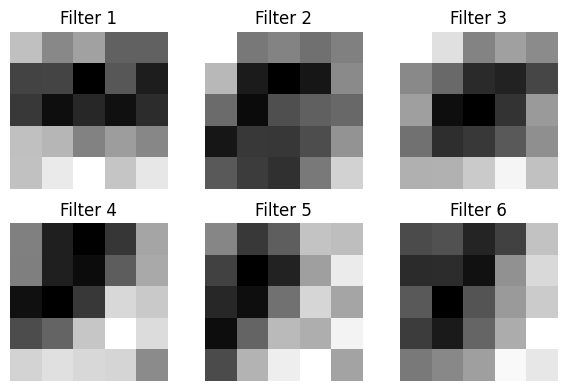

In [9]:
import matplotlib.pyplot as plt

# Get first convolutional layer weights
filters = model.conv1.weight.data.clone()

fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.flatten()

for i in range(6):  # LeNet conv1 has 6 filters
    axes[i].imshow(filters[i, 0, :, :], cmap='gray')
    axes[i].set_title(f"Filter {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


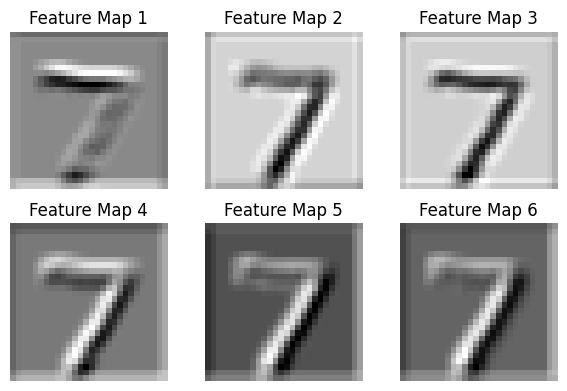

In [10]:
# Take one image from test set
images, _ = next(iter(test_loader))
image = images[0].unsqueeze(0)  # shape [1,1,28,28]

# Pass through first conv layer
with torch.no_grad():
    feature_maps = model.conv1(image)

fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.flatten()

for i in range(6):
    axes[i].imshow(feature_maps[0, i].numpy(), cmap='gray')
    axes[i].set_title(f"Feature Map {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Conv2 feature map shape: torch.Size([1, 16, 10, 10])


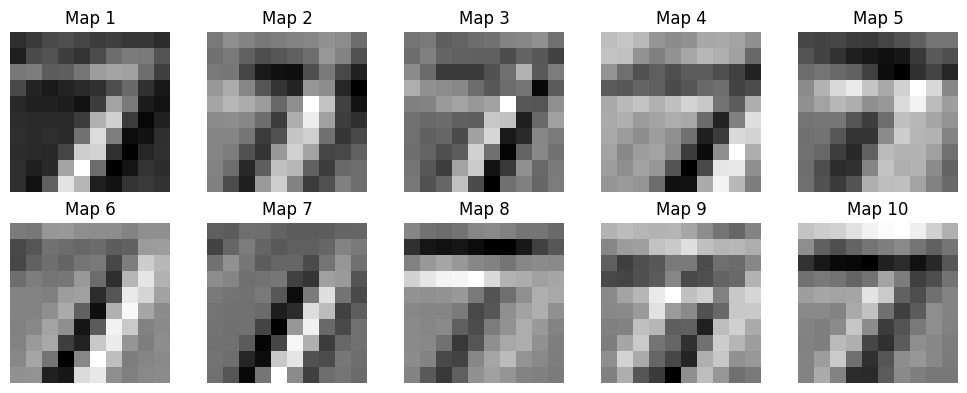

In [11]:
# Get one image from test set
images, _ = next(iter(test_loader))
image = images[0].unsqueeze(0)  # shape [1,1,28,28]

# Pass through Conv1 → ReLU → Pool → Conv2
with torch.no_grad():
    x = torch.relu(model.conv1(image))  # Apply the first convolution
    x = model.pool1(x)  # Apply the first pooling layer
    feature_maps_conv2 = model.conv2(x)  # Apply the second convolution
    x = model.pool2(feature_maps_conv2)

print("Conv2 feature map shape:", feature_maps_conv2.shape)

# Plot first 10 feature maps (there are 16 in LeNet conv2)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(feature_maps_conv2[0, i].numpy(), cmap='gray')
    axes[i].set_title(f"Map {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
